In [1]:
# from google.colab import drive
# drive.mount('/content/gdrive')
# %cd /content/gdrive/My\ Drive/masters

In [1]:
import os
import logging as log
from time import strftime
from copy import deepcopy
from torch import nn, optim
import torch.nn.functional as F
from utils.data_processing import *
from logger.logger import setup_logging
from utils.configs import BaseConf
from utils.utils import write_json, Timer
from models.kangkang_fnn_models import KangFeedForwardNetwork, SimpleKangFNN, evaluate_fnn
from dataloaders.flat_loader import FlatDataLoaders, MockLoader, MockLoaders
from datasets.flat_dataset import FlatDataGroup
from utils.metrics import PRCurvePlotter, ROCCurvePlotter, LossPlotter, PerTimeStepPlotter
from sklearn.metrics import accuracy_score, average_precision_score, roc_auc_score
from models.model_result import ModelResult, ModelMetrics, save_results, save_metrics, compare_all_models, get_models_metrics
from utils.mock_data import mock_fnn_data_classification
from utils.plots import im
from utils.utils import pshape, get_data_sub_paths, by_ref
from trainers.generic_trainer import train_model
from models.kangkang_fnn_models import train_epoch_for_fnn

from utils.metrics import best_threshold, get_y_pred, get_y_pred_by_thresholds, best_thresholds
from time import time
from torch.optim import lr_scheduler


In [2]:
data_sub_paths = get_data_sub_paths()
print(np.sort(data_sub_paths))

['T1H-X3400M-Y3520M_2014-01-01_2016-01-01_#7cd'
 'T24H-X1700M-Y1760M_2014-01-01_2019-01-01_#828'
 'T24H-X255M-Y220M_2012-01-01_2019-01-01_#c97'
 'T24H-X425M-Y440M_2012-01-01_2019-01-01_#827'
 'T24H-X850M-Y880M_2012-01-01_2019-01-01_#826']


In [3]:
data_sub_paths = by_ref("c97")
data_sub_paths

['T24H-X255M-Y220M_2012-01-01_2019-01-01_#c97']

In [4]:
from pprint import pprint
conf = BaseConf()

In [5]:
log.getLogger().setLevel("INFO")

In [6]:
# T24H-X850M-Y880M_2012-01-01_2019-01-01

data_sub_path = data_sub_paths[0]

# manually set
conf = BaseConf()
conf.seed = int(time()) # 3
conf.model_name = "KangFNN" # "SimpleKangFNN" # "KangFNN"  # needs to be created
conf.data_path = f"./data/processed/{data_sub_path}/"

if not os.path.exists(conf.data_path):
    raise Exception(f"Directory ({conf.data_path}) needs to exist.")

conf.model_path = f"{conf.data_path}models/{conf.model_name}/"
os.makedirs(conf.data_path, exist_ok=True)
os.makedirs(conf.model_path, exist_ok=True)

# logging config is set globally thus we only need to call this in this file
# imported function logs will follow the configuration
setup_logging(save_dir=conf.model_path, log_config='./logger/standard_logger_config.json', default_level=log.INFO)
log.info("=====================================BEGIN=====================================")

info = deepcopy(conf.__dict__)
info["start_time"] = strftime("%Y-%m-%dT%H:%M:%S")

# DATA LOADER SETUP
np.random.seed(conf.seed)
use_cuda = True # torch.cuda.is_available()
if use_cuda:
    torch.cuda.manual_seed(conf.seed)
else:
    torch.manual_seed(conf.seed)

device = torch.device("cuda:0" if use_cuda else "cpu")
log.info(f"Device: {device}")
info["device"] = device.type
conf.device = device

2020-10-29T18:27:10 | root | INFO | =====================================BEGIN=====================================
2020-10-29T18:27:10 | root | INFO | Device: cuda:0


In [7]:
# SET THE HYPER PARAMETERS
conf.resume = False
conf.early_stopping = True
conf.patience = 1000
conf.min_epochs = 800
conf.max_epochs = 50 # conf.min_epochs + conf.patience + 100
conf.dropout = 0 # 0.5 # should be between 0.5 and 0.8 for input dropout rates
conf.weight_decay = 0  # [0, 1e-8, 1e-6, 1e-4, 1e-2]
conf.checkpoint = "latest" #"latest" # ["best_val", "best_trn", "best_trn_val"]
conf.lr = 1e-3
conf.shaper_top_k = -1
conf.batch_size = 128
conf.use_classification = True
conf.train_set_first = True

MOCK = False

if MOCK:
    # MOCK THE DATA
    vector_size= [5,5,5]#[37,65,512]    
    class_split=0.5
    train_loader = MockLoader(vector_size, conf.batch_size, n_samples=1000, class_split=class_split)
    validation_loader = MockLoader(vector_size, conf.batch_size, n_samples=200, class_split=class_split)
    test_loader = MockLoader(vector_size, conf.batch_size, n_samples=300, class_split=class_split)
    loaders = MockLoaders(train_loader,validation_loader,test_loader)
else:
    # CRIME DATA - sub-sample classes to even out class label ratios
    conf.sub_sample_test_set = 0
    conf.sub_sample_train_set = 2 # 1 # 2 # 5 # 10
    conf.sub_sample_validation_set = 2 # 1 # 2 # 5 # 10

    data_group = FlatDataGroup(data_path=conf.data_path, conf=conf)
    loaders = FlatDataLoaders(data_group=data_group, conf=conf)

conf.freqstr = data_group.t_range.freqstr    

# SET LOSS FUNCTION
# size averaged - so more epochs or larger lr for smaller batches
loss_function = nn.CrossEntropyLoss()
# if conf.use_classification:
#     loss_function = nn.CrossEntropyLoss()
#     log.info("loss function: cross entropy loss")
# else:
#     loss_function = nn.MSELoss()
#     log.info("loss function: mean square error loss")

# SETUP MODEL
train_set = loaders.train_loader.dataset
indices, spc_feats, tmp_feats, env_feats, target, labels = train_set[train_set.min_index]
spc_size, tmp_size, env_size = spc_feats.shape[-1], tmp_feats.shape[-1], env_feats.shape[-1]


if conf.model_name == "SimpleKangFNN":
    model_arch = {
        "h_size0": 10,
        "h_size1": 10,
        "h_size2": 10,
    }
    model = SimpleKangFNN(spc_size=spc_size,
                          tmp_size=tmp_size,
                          env_size=env_size,
                          dropout_p=conf.dropout,
                          model_arch=model_arch)
else:
#     model_arch = {
#         "scp_net_h0": 64,
#         "scp_net_h1": 32,
#         "tmp_net_h0": 64,
#         "tmp_net_h1": 32,
#         "env_net_h0": 64,
#         "env_net_h1": 32,
#         "final_net_h1": 64,
#     }
    
    model_arch = None # if none will use default architechture
    
    model = KangFeedForwardNetwork(spc_size=spc_size,
                                   tmp_size=tmp_size,
                                   env_size=env_size,
                                   dropout_p=conf.dropout,
                                   model_arch=model_arch)

    
pprint(conf)
model.to(conf.device)

# SETUP OPTIMISER
parameters = model.parameters()

# important note: using weight decay (l2 penalty) can prohibit long term memory in LSTM networks
# - use gradient clipping instead
optimiser = optim.Adam(params=parameters, lr=conf.lr, weight_decay=conf.weight_decay, amsgrad=False)
# optimiser = optim.SGD(params=parameters, lr=conf.lr)
scheduler = None
# scheduler = lr_scheduler.CosineAnnealingLR(optimizer=optimiser, T_max=10)#conf.max_epochs//5)
# scheduler = lr_scheduler.ReduceLROnPlateau(optimiser, mode='min', factor=0.1, patience=10,
#                                            threshold=0.0001, threshold_mode='rel', cooldown=0,
#                                            min_lr=0, eps=1e-08, verbose=False)


##### RESUME LOGIC
if conf.resume:  # todo check if the files actually exist
    try:
        # resume from previous check point or resume from best validaton score checkpoint
        # load model state
        model_state_dict = torch.load(f"{conf.model_path}model_{conf.checkpoint}.pth",
                                      map_location=conf.device.type)
        model.load_state_dict(model_state_dict)
        
        # load optimiser state
        optimiser_state_dict = torch.load(f"{conf.model_path}optimiser_{conf.checkpoint}.pth",
                                          map_location=conf.device.type)
        optimiser.load_state_dict(optimiser_state_dict) 

        # new optimiser hyper-parameters
        optimiser.param_groups[0]['lr'] = conf.lr
        optimiser.param_groups[0]['weight_decay'] = conf.weight_decay

        # new model hyper-parameters
        model.dropout.p = conf.dropout # note that drop out is not part of the saved state dict

    except Exception as e:
        log.error(f"Nothing to resume from, training from scratch \n\t-> {e}")

2020-10-29T18:27:10 | root | INFO | Initialising Flat Data Group
2020-10-29T18:27:10 | root | INFO | loading crimes grids WITHOUT crime types
2020-10-29T18:27:10 | root | INFO | 	t_range: (2558,) 2012-01-01 00:00:00 -> 2019-01-01 00:00:00
2020-10-29T18:27:10 | root | INFO | 	target_len:	2191	(100.000%)
2020-10-29T18:27:10 | root | INFO | 	trn_val_size:	1831	(83.569%)
2020-10-29T18:27:10 | root | INFO | 	trn_size:	1374	(62.711%)
2020-10-29T18:27:10 | root | INFO | 	val_size:	457	(20.858%)
2020-10-29T18:27:10 | root | INFO | 	tst_size:	360 	(16.431%)
fitted historic average: step (1) and max_steps (-1)
{'batch_size': 128,
 'cap_crime_percentile': 0,
 'checkpoint': 'latest',
 'data_path': './data/processed/T24H-X255M-Y220M_2012-01-01_2019-01-01_#c97/',
 'device': device(type='cuda', index=0),
 'dropout': 0,
 'early_stopping': True,
 'flatten_grid': True,
 'freqstr': '24H',
 'lr': 0.001,
 'max_epochs': 50,
 'min_epochs': 800,
 'model_name': 'KangFNN',
 'model_path': './data/processed/T24H-

2020-10-29T18:27:12 | root | INFO | 
 ====================== Training KangFNN ====================== 

2020-10-29T18:27:12 | root | INFO | 
 ====================== Config Values ====================== 
{'batch_size': 128,
 'cap_crime_percentile': 0,
 'checkpoint': 'latest',
 'data_path': './data/processed/T24H-X255M-Y220M_2012-01-01_2019-01-01_#c97/',
 'device': device(type='cuda', index=0),
 'dropout': 0,
 'early_stopping': True,
 'flatten_grid': True,
 'freqstr': '24H',
 'lr': 0.001,
 'max_epochs': 50,
 'min_epochs': 800,
 'model_name': 'KangFNN',
 'model_path': './data/processed/T24H-X255M-Y220M_2012-01-01_2019-01-01_#c97/models/KangFNN/',
 'n_channels': 3,
 'n_layers': 3,
 'n_steps_c': 3,
 'n_steps_p': 3,
 'n_steps_q': 3,
 'num_workers': 12,
 'pad_width': 0,
 'patience': 1000,
 'resume': False,
 'seed': 1603988830,
 'seq_len': 1,
 'shaper_threshold': 0,
 'shaper_top_k': -1,
 'shuffle': True,
 'sub_sample_test_set': 0,
 'sub_sample_train_set': 2,
 'sub_sample_validation_set': 2,
 't

2020-10-29T18:28:49 | root | INFO | 	Loss (Val): 		0.52337347
2020-10-29T18:28:49 | root | INFO | 	Loss (Best Val): 	0.51058449
2020-10-29T18:28:49 | root | INFO | 	Loss (Trn Val Dif): 	0.01929510

2020-10-29T18:28:49 | root | INFO | Epoch: 0019/0050
2020-10-29T18:28:53 | root | INFO | 	Loss (Trn): 		0.50264266
2020-10-29T18:28:53 | root | INFO | 	Loss (Best Trn): 	0.50264266
2020-10-29T18:28:53 | root | INFO | 	Loss (Val): 		0.52004763
2020-10-29T18:28:53 | root | INFO | 	Loss (Best Val): 	0.51058449
2020-10-29T18:28:53 | root | INFO | 	Loss (Trn Val Dif): 	0.01740496

2020-10-29T18:28:53 | root | INFO | Epoch: 0020/0050
2020-10-29T18:28:58 | root | INFO | 	Loss (Trn): 		0.50006246
2020-10-29T18:28:58 | root | INFO | 	Loss (Best Trn): 	0.50006246
2020-10-29T18:28:58 | root | INFO | 	Loss (Val): 		0.52186232
2020-10-29T18:28:58 | root | INFO | 	Loss (Best Val): 	0.51058449
2020-10-29T18:28:58 | root | INFO | 	Loss (Trn Val Dif): 	0.02179987

2020-10-29T18:28:58 | root | INFO | Epoch: 0

2020-10-29T18:30:29 | root | INFO | 	Loss (Trn): 		0.42276375
2020-10-29T18:30:29 | root | INFO | 	Loss (Best Trn): 	0.42276375
2020-10-29T18:30:29 | root | INFO | 	Loss (Val): 		0.63586809
2020-10-29T18:30:29 | root | INFO | 	Loss (Best Val): 	0.51058449
2020-10-29T18:30:29 | root | INFO | 	Loss (Trn Val Dif): 	0.21310434

2020-10-29T18:30:29 | root | INFO | Epoch: 0041/0050
2020-10-29T18:30:34 | root | INFO | 	Loss (Trn): 		0.41549239
2020-10-29T18:30:34 | root | INFO | 	Loss (Best Trn): 	0.41549239
2020-10-29T18:30:34 | root | INFO | 	Loss (Val): 		0.65131139
2020-10-29T18:30:34 | root | INFO | 	Loss (Best Val): 	0.51058449
2020-10-29T18:30:34 | root | INFO | 	Loss (Trn Val Dif): 	0.23581901

2020-10-29T18:30:34 | root | INFO | Epoch: 0042/0050
2020-10-29T18:30:39 | root | INFO | 	Loss (Trn): 		0.40779848
2020-10-29T18:30:39 | root | INFO | 	Loss (Best Trn): 	0.40779848
2020-10-29T18:30:39 | root | INFO | 	Loss (Val): 		0.67724723
2020-10-29T18:30:39 | root | INFO | 	Loss (Best Val)

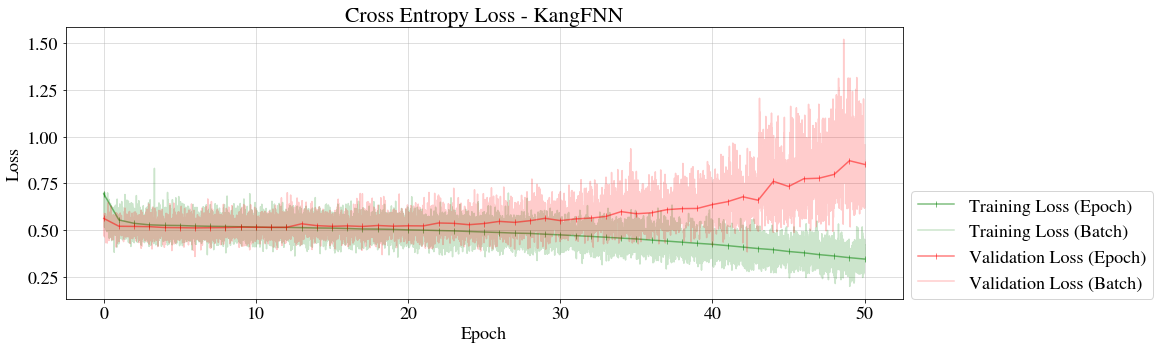

In [8]:
trn_epoch_losses, val_epoch_losses, stopped_early = train_model(
    model=model,
    optimiser=optimiser,
    loaders=loaders,
    train_epoch_fn=train_epoch_for_fnn,
    loss_fn=loss_function,
    conf=conf,
    scheduler=scheduler,
)    

print(f"stopped_early: {stopped_early}") # use the current epoch instead
# if stopped_early -> continue with best_model - new hyper-parameters -> no n 

In [10]:
from utils.interactive import plot_interactive_epoch_losses
plot_interactive_epoch_losses(trn_epoch_losses, val_epoch_losses)

# Evaluation

In [16]:
# Load latest or best validation model
# conf.checkpoint = "latest"
conf.checkpoint = "best_val"
# conf.checkpoint = "best_trn"

conf.model_name = f"{model.name}"

log.info(f"Loading model from checkpoint ({conf.checkpoint}) for evaluation")

# resume from previous check point or resume from best validaton score checkpoint
# load model state
model_state_dict = torch.load(f"{conf.model_path}model_{conf.checkpoint}.pth",
                                map_location=conf.device.type)
model.load_state_dict(model_state_dict)


2020-10-29T18:36:27 | root | INFO | Loading model from checkpoint (best_val) for evaluation


<All keys matched successfully>

In [17]:
conf.sub_sample_test_set = 0
conf.sub_sample_train_set = 0
conf.sub_sample_validation_set = 0

loaders = FlatDataLoaders(data_group=data_group, conf=conf)

In [18]:
# todo set the train_loader to eval so that it does not subsample
trn_y_count, trn_y_class, trn_y_score, trn_t_range = evaluate_fnn(model=model,
                                                        batch_loader=loaders.train_loader,
                                                        conf=conf)

tst_y_count, tst_y_class, tst_y_score, tst_t_range = evaluate_fnn(model=model,
                                                        batch_loader=loaders.test_loader,
                                                        conf=conf)

thresh = best_threshold(y_class=trn_y_class,
                        y_score=trn_y_score)

tst_y_pred = get_y_pred(thresh=thresh,
                        y_score=tst_y_score)    

tst_y_count = loaders.data_group.to_counts(tst_y_count)     
        
save_metrics(y_count=tst_y_count,
             y_pred=tst_y_pred,
             y_score=tst_y_score,
             t_range=tst_t_range,
             shaper=data_group.shaper,                
             conf=conf)   

# save_results(y_true=tst_y_true,
#              y_pred=tst_y_pred,
#              probas_pred=tst_probas_pred,
#              t_range=tst_t_range,
#              shaper=data_group.shaper,                
#              conf=conf)

2020-10-29T18:36:38 | root | INFO | f1_score: 0.3976658950617284 at index 257622, new threshold 0.7318394780158997
2020-10-29T18:36:40 | root | INFO | 
            MODEL METRICS (Over All Samples)
            Class Balance (Crime:No-Crime) - 1:7.575
                Model Name: KangFNN
                    ROC AUC:            0.82369                
                    Average Precision:  0.43920
                    Precision:          0.42465
                    Recall:             0.46489
                    Accuracy:           0.86414
                    MCC:                0.36715
                    PAI:                4.23991
                    MAE:                0.37351
                    RMSE:               0.54081      
            


2020-10-29T18:36:43 | root | INFO | 
                     ROC AUC  Avg. Precision  Precision    Recall  F1 Score  \
Model Name                                                                    
Uni. Mov. Avg.      0.828901        0.443627   0.352204  0.615725  0.448093   
Ind-Hawkes Model    0.826035        0.439863   0.402802  0.505474  0.448335   
KangFNN             0.823695        0.439203   0.424646  0.464890  0.443858   
Historic Average    0.825739        0.437915   0.404360  0.506580  0.449735   
Global Average      0.824705        0.431115   0.407428  0.485237  0.442942   
ST-RESNET           0.805127        0.430035   0.394377  0.491762  0.437718   
Previous Time Step  0.614230        0.204356   0.314049  0.313944  0.313997   

                    Accuracy       MCC       PAI      RMSE       MAE  
Model Name                                                            
Uni. Mov. Avg.      0.823120  0.371433  3.318306  0.523886  0.161364  
Ind-Hawkes Model    0.854934  0.369176

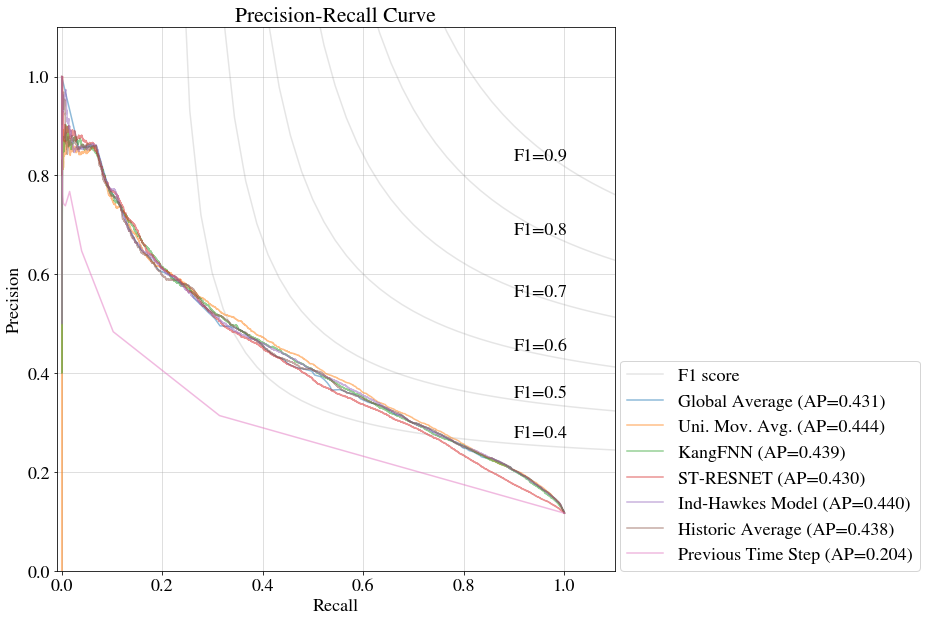

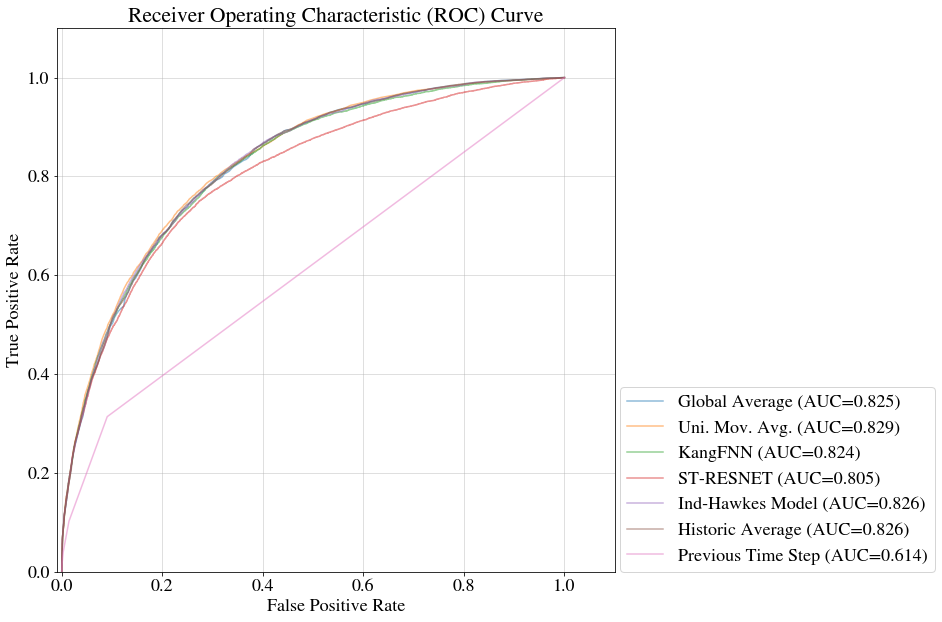

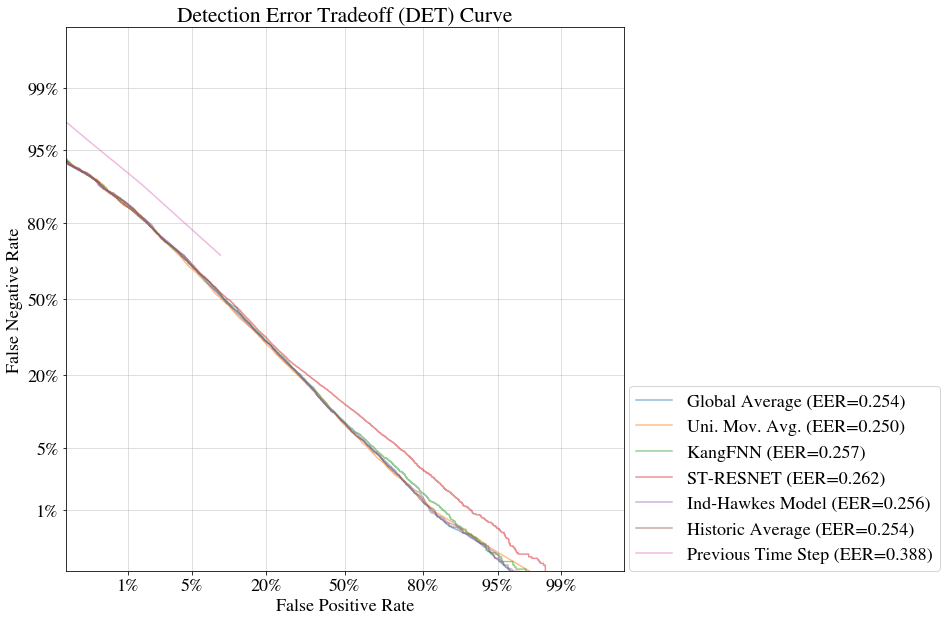

,ROC AUC,Avg. Precision,Precision,Recall,F1 Score,Accuracy,MCC,PAI,RMSE,MAE
Model Name,,,,,,,,,,
Uni. Mov. Avg.,0.828901,0.443627,0.352204,0.615725,0.448093,0.823120,0.371433,3.318306,0.523886,0.161364
Ind-Hawkes Model,0.826035,0.439863,0.402802,0.505474,0.448335,0.854934,0.369176,3.952215,0.488214,0.181277
KangFNN,0.823695,0.439203,0.424646,0.464890,0.443858,0.864142,0.367145,4.239908,0.540809,0.373514
Historic Average,0.825739,0.437915,0.404360,0.506580,0.449735,0.855437,0.370822,3.941047,0.527602,0.160331
Global Average,0.824705,0.431115,0.407428,0.485237,0.442942,0.857668,0.363879,4.004898,0.527873,0.160280
ST-RESNET,0.805127,0.430035,0.394377,0.491762,0.437718,0.852664,0.356976,3.854598,0.527998,0.162866
Previous Time Step,0.614230,0.204356,0.314049,0.313944,0.313997,0.840026,0.223452,3.236038,0.523992,0.160517


In [19]:
compare_all_models(data_path=conf.data_path)

In [66]:
# from utils.interactive import plot_interactive_roc, plot_interactive_pr, plot_interactive_det
# plot_interactive_pr(conf.data_path,beta=1).show()
# plot_interactive_roc(conf.data_path).show()
# plot_interactive_det(conf.data_path).show()

### View Training Predictions

In [20]:
trn_y_count, trn_y_class, trn_y_score, trn_t_range = evaluate_fnn(model=model,
                                                                  batch_loader=loaders.train_loader,
                                                                  conf=conf)

trn_y_count = data_group.shaper.unsqueeze(trn_y_count)
trn_y_class = data_group.shaper.unsqueeze(trn_y_class)
trn_y_score = data_group.shaper.unsqueeze(trn_y_score)

from utils.interactive import InteractiveHeatmapsWithLines

InteractiveHeatmapsWithLines(
    date_range=trn_t_range, 
    col_wrap=3,
    Counts=trn_y_count[:,0], 
    Hotspots=trn_y_class[:,0],
    Probabilities=trn_y_score[:,0],
).app

### View testing predictions

In [31]:
from utils.interactive import InteractiveHeatmapsWithLines

tst_y_count, tst_y_class, tst_y_score, tst_t_range = evaluate_fnn(model=model,
                                                                  batch_loader=loaders.test_loader,
                                                                  conf=conf)

# thresh = best_threshold(y_class=trn_y_class,
#                         y_score=trn_y_score)

thresh = best_threshold(y_class=tst_y_class,
                        y_score=tst_y_score)

tst_y_pred = get_y_pred(thresh=thresh,
                        y_score=tst_y_score) 

tst_y_count = data_group.shaper.unsqueeze(tst_y_count)
tst_y_class = data_group.shaper.unsqueeze(tst_y_class)
tst_y_score = data_group.shaper.unsqueeze(tst_y_score)
tst_y_pred = data_group.shaper.unsqueeze(tst_y_pred)


kwargs = {
    "True Counts":tst_y_count[:,0], 
    "True Hotspots":tst_y_class[:,0],
    "Predicted Probabilities":tst_y_score[:,0],
    "Predicted Hotspots":tst_y_pred[:,0],
}

InteractiveHeatmapsWithLines(
    date_range=tst_t_range, 
    col_wrap=4,
    **kwargs,
).app

2020-10-29T19:13:42 | root | INFO | f1_score: 0.44895358525707013 at index 65551, new threshold 0.7093508839607239


-----

## All in one code

In [ ]:
import os
import logging as log
from time import strftime
from copy import deepcopy
from torch import nn, optim
import torch.nn.functional as F
from utils.data_processing import *
from logger.logger import setup_logging
from utils.configs import BaseConf
from utils.utils import write_json, Timer
from models.kangkang_fnn_models import KangFeedForwardNetwork, SimpleKangFNN

from dataloaders.flat_loader import FlatDataLoaders, MockLoader, MockLoaders
from datasets.flat_dataset import FlatDataGroup
from utils.metrics import PRCurvePlotter, ROCCurvePlotter, LossPlotter, PerTimeStepPlotter
from sklearn.metrics import accuracy_score, average_precision_score, roc_auc_score
from models.model_result import ModelResult, ModelMetrics, save_metrics, compare_all_models, get_models_metrics
from utils.mock_data import mock_fnn_data_classification
from utils.plots import im
from utils.utils import pshape
from trainers.generic_trainer import train_model

from models.kangkang_fnn_models import train_epoch_for_fnn

from utils.metrics import best_threshold, get_y_pred

In [ ]:
data_sub_paths = os.listdir("./data/processed/")
data_sub_paths

In [ ]:
data_sub_paths = ['T24H-X255M-Y220M_2012-01-01_2019-01-01_#c97']

In [ ]:

# data_dim_str = "T24H-X255M-Y220M"#"T24H-X850M-Y880M" # "T24H-X85M-Y110M" #"T1H-X1700M-Y1760M"  # needs to exist  
for data_sub_path in data_sub_paths:
    model_name = "Kang FNN"  # needs to be created    
    data_path = f"./data/processed/{data_sub_path}/"
    compare_all_models(data_path=data_path)

    if not os.path.exists(data_path):
        raise Exception(f"Directory ({data_path}) needs to exist.")

    model_path = data_path + f"models/{model_name}/"
    os.makedirs(data_path, exist_ok=True)
    os.makedirs(model_path, exist_ok=True)

    # logging config is set globally thus we only need to call this in this file
    # imported function logs will follow the configuration
    setup_logging(save_dir=model_path, log_config='./logger/standard_logger_config.json', default_level=log.INFO)
    log.info("=====================================BEGIN=====================================")

    timer = Timer()
    # manually set the config
    conf_dict = {
        "seed": 3,
        "use_cuda": True,
        
        "use_crime_types": False,
        
        # data group/data set related
        "val_ratio": 0.1,  # ratio of the total dataset
        "tst_ratio": 0.3,# ratio of the total dataset
        "seq_len": 1,
        "flatten_grid": True,  # if the shaper should be used to squeeze the data
        
        # shaper related 
        "shaper_top_k": -1,  # if less then 0, top_k will not be applied
        "shaper_threshold": 0,

        
        # data loader related
        "sub_sample_train_set": 1,
        "sub_sample_validation_set": 1,
        "sub_sample_validation_set": 0,
        
        # training parameters
        "resume": False,
        "early_stopping": False,
        "tolerance": 1e-8,
        "lr": 1e-3,
        "weight_decay": 1e-8,
        "max_epochs": 1,
        "batch_size": 64,
        "dropout": 0.2,
        "shuffle": False,
        "num_workers": 6,
        
        # attached global variables - bad practice -find alternative
        "device": None,  # pytorch device object [CPU|GPU]
        "timer": Timer(),
        "model_name": model_name,
        "model_path": model_path,
        "checkpoint": "best",

        "pad_width": 0,
        
        "use_seq_loss": True,
        "use_classification": True,
        "use_historic_average": True,
    }
    conf = BaseConf(conf_dict=conf_dict)

    info = deepcopy(conf.__dict__)
    info["start_time"] = strftime("%Y-%m-%dT%H:%M:%S")

    # DATA LOADER SETUP
    np.random.seed(conf.seed)
    use_cuda = torch.cuda.is_available()
    if use_cuda:
        torch.cuda.manual_seed( conf.seed)
    else:
        torch.manual_seed(conf.seed)

    device = torch.device("cuda:0" if use_cuda else "cpu")
    log.info(f"Device: {device}")
    info["device"] = device.type
    conf.device = device

    log.getLogger().setLevel("INFO")

    # SET THE HYPER PARAMETERS
    conf.resume = False
    conf.early_stopping = False
    conf.max_epochs = 1
    conf.dropout = 0#0.2
    conf.weight_decay = 1e-8
    conf.checkpoint = "best" # ["best"|"latest"]
    conf.lr = 5e-4
    conf.shaper_top_k = -1
    conf.batch_size =  256

    MOCK = False

    if MOCK:
        # MOCK THE DATA
        vector_size= [5,5,5]#[37,65,512]    
        class_split=0.5
        train_loader = MockLoader(vector_size, conf.batch_size, n_samples=1000, class_split=class_split)
        validation_loader = MockLoader(vector_size, conf.batch_size, n_samples=200, class_split=class_split)
        test_loader = MockLoader(vector_size, conf.batch_size, n_samples=300, class_split=class_split)
        loaders = MockLoaders(train_loader,validation_loader,test_loader)
    else:
        # CRIME DATA
        conf.sub_sample_test_set = False
        conf.sub_sample_train_set = True
        conf.sub_sample_validation_set = True

        data_group = FlatDataGroup(data_path=data_path, conf=conf)
        loaders = FlatDataLoaders(data_group=data_group, conf=conf)

    conf.freqstr = data_group.t_range.freqstr    

    # SET LOSS FUNCTION
    # size averaged - so more epochs or larger lr for smaller batches
    loss_function = nn.CrossEntropyLoss()  

    # SETUP MODEL
    train_set = loaders.train_loader.dataset
    indices, spc_feats, tmp_feats, env_feats, target = train_set[train_set.min_index]
    spc_size, tmp_size, env_size = spc_feats.shape[-1], tmp_feats.shape[-1], env_feats.shape[-1]


    model_arch = {
        "h_size0": 100,
        "h_size1": 100,
        "h_size2": 100,
    }
    model = SimpleKangFNN(spc_size=spc_size,
                        tmp_size=tmp_size,
                        env_size=env_size,
                        dropout_p=conf.dropout,
                        model_arch=model_arch)

    # model_arch = {
    #     "scp_net_h0": 64,
    #     "scp_net_h1": 32,
    #     "tmp_net_h0": 64,
    #     "tmp_net_h1": 32,
    #     "env_net_h0": 64,
    #     "env_net_h1": 32,
    #     "final_net_h1": 64,
    # }
    # model = KangFeedForwardNetwork(spc_size=spc_size,
    #                                  tmp_size=tmp_size,
    #                                  env_size=env_size,
    #                                  dropout_p=conf.dropout,
    #                                  model_arch=model_arch)

    model.to(conf.device)

    # SETUP OPTIMISER
    parameters = model.parameters()

    # important note: using weight decay (l2 penalty) can prohibit long term memory in LSTM networks
    # - use gradient clipping instead
    optimiser = optim.Adam(params=parameters, lr=conf.lr, weight_decay=conf.weight_decay)

    ##### RESUME LOGIC
    if conf.resume:  # todo check if the files actually exist
        try:
            # resume from previous check point or resume from best validaton score checkpoint
            # load model state
            model_state_dict = torch.load(f"{conf.model_path}model_{conf.checkpoint}.pth",
                                        map_location=conf.device.type)
            model.load_state_dict(model_state_dict)
            
            # load optimiser state
            optimiser_state_dict = torch.load(f"{conf.model_path}optimiser_{conf.checkpoint}.pth",
                                            map_location=conf.device.type)
            optimiser.load_state_dict(optimiser_state_dict) 

            # new optimiser hyper-parameters
            optimiser.param_groups[0]['lr'] = conf.lr
            optimiser.param_groups[0]['weight_decay'] = conf.weight_decay

            # new model hyper-parameters
            model.dropout.p = conf.dropout # note that drop out is not part of the saved state dict

        except Exception as e:
            log.error(f"Nothing to resume from, training from scratch \n\t-> {e}")

    trn_epoch_losses, val_epoch_losses, stopped_early = train_model(model=model,
                                                                        optimiser=optimiser,
                                                                        loaders=loaders,
                                                                        train_epoch_fn=train_epoch_for_fnn,
                                                                        loss_fn=loss_function,
                                                                        conf=conf)    

    print(f"stopped_early: {stopped_early}") # use the current epoch instead
    # if stopped_early -> continue with best_model - new hyper-parameters -> no n 

    # Load latest or best validation model
    # conf.checkpoint = "best"
    conf.checkpoint = "best"

    log.info(f"Loading model from checkpoint ({conf.checkpoint}) for evaluation")

    # resume from previous check point or resume from best validaton score checkpoint
    # load model state
    model_state_dict = torch.load(f"{conf.model_path}model_{conf.checkpoint}.pth",
                                    map_location=conf.device.type)
    model.load_state_dict(model_state_dict)


    conf.sub_sample_test_set = False
    conf.sub_sample_train_set = False
    conf.sub_sample_validation_set = False

    loaders = FlatDataLoaders(data_group=data_group, conf=conf)

    def evaluate_fnn(model, batch_loader, conf):    
        """
        Only used to get probas in a time and location based format. The hard predictions should be done outside 
        this function where the threshold is determined using only the training data
        """
        probas_pred = np.zeros(batch_loader.dataset.target_shape,dtype=np.float)
        y_true = batch_loader.dataset.targets[-len(probas_pred):]
        t_range = batch_loader.dataset.t_range[-len(probas_pred):]
        
        
        with torch.set_grad_enabled(False):
            model.eval()
                
            num_batches = batch_loader.num_batches
            for indices, spc_feats, tmp_feats, env_feats, targets in batch_loader:
                current_batch = batch_loader.current_batch

                # Transfer to PyTorch Tensor and GPU
                spc_feats = torch.Tensor(spc_feats[0]).to(conf.device) # only taking [0] for fnn
                tmp_feats = torch.Tensor(tmp_feats[0]).to(conf.device) # only taking [0] for fnn
                env_feats = torch.Tensor(env_feats[0]).to(conf.device) # only taking [0] for fnn
                targets = torch.LongTensor(targets[0,:,0]).to(conf.device) # only taking [0] for fnn
                out = model(spc_feats, tmp_feats, env_feats)

                batch_probas_pred = F.softmax(out,dim=-1)[:,1].cpu().numpy() # select class1 prediction
                
                for i, p in zip(indices,batch_probas_pred):
                    n,c,l = i   
                    probas_pred[n,c,l] = p

        
        return y_true, probas_pred, t_range


    # todo set the train_loader to eval so that it does not subsample
    trn_y_true, trn_probas_pred, trn_t_range = evaluate_fnn(model=model,
                                                            batch_loader=loaders.train_loader,
                                                            conf=conf)

    thresh = best_threshold(y_true=trn_y_true,
                        probas_pred=trn_probas_pred)

    tst_y_true, tst_probas_pred, tst_t_range = evaluate_fnn(model=model,
                                                            batch_loader=loaders.test_loader,
                                                            conf=conf)    
        
        

    tst_y_pred = get_y_pred(thresh, tst_probas_pred)    
        
        
    save_metrics(y_true=tst_y_true,
                y_pred=tst_y_pred,
                probas_pred=tst_probas_pred,
                t_range=tst_t_range,
                shaper=data_group.shaper,                
                conf=conf)   

    compare_all_models(data_path=data_path)

In [ ]:
from time import sleep
timer = Timer()
timer.reset()
i = 0
for v in loaders.train_loader:
    i += 1
print(f"i: {i} and train loader time {timer.check()}")    

timer.reset()
i = 0
for v in loaders.validation_loader:
    i += 1
print(f"i: {i} and val loader time {timer.check()}")    

timer.reset()
i = 0
for v in loaders.test_loader:
    i += 1
print(f"i: {i} and test loader time {timer.check()}")    

In [ ]:
from sklearn.metrics import precision_recall_curve


def safe_f1_score(pr):
    p, r = pr
    if p + r == 0:
        return 0
    else:
        return 2 * (p * r) / (p + r)

precision, recall, thresholds = precision_recall_curve(trn_y_true.flatten(), trn_probas_pred.flatten())
precision, recall, thresholds = precision_recall_curve(tst_y_true.flatten(), tst_probas_pred.flatten())
scores = np.array(list(map(safe_f1_score, zip(precision, recall))))
index_array = np.argmax(scores)  # almost always a singular int, and not an array

In [ ]:
plt.plot(scores)
plt.scatter(index_array,scores[index_array])
plt.show()

plt.plot(recall, precision)
plt.scatter(recall, precision, s=scores*5,alpha=.1)
plt.show()

**Metrics per cell**

In [ ]:
print("ap_per_cell\n")
ap_per_cell = average_precision_score_per_cell(tst_y_true, tst_probas_pred)
ap_per_cell = np.nan_to_num(ap_per_cell)
ap_per_cell = data_group.shaper.unsqueeze(ap_per_cell)[0,0]
im(ap_per_cell)

print("roc_per_cell\n")
roc_per_cell = roc_auc_score_per_cell(tst_y_true, tst_probas_pred)
roc_per_cell = np.nan_to_num(roc_per_cell)
roc_per_cell = data_group.shaper.unsqueeze(roc_per_cell)[0,0]
im(roc_per_cell)

print("p_per_cell\n")
p_per_cell = precision_score_per_cell(tst_y_true, tst_y_pred)
p_per_cell = data_group.shaper.unsqueeze(p_per_cell)[0,0]
im(p_per_cell)

print("r_per_cell\n")
r_per_cell = precision_score_per_cell(tst_y_true, tst_y_pred)
r_per_cell = data_group.shaper.unsqueeze(r_per_cell)[0,0]
im(r_per_cell)

**Metrics per time slot**: should be one plot per metric - with multiple models

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
freqstr = data_group.t_range.freqstr

N = tst_y_true.shape[0]

ap_per_time = average_precision_score_per_time_slot(y_true=tst_y_true,
                                                    probas_pred=tst_probas_pred)

ap_per_time = np.nan_to_num(ap_per_time)

roc_per_time = roc_auc_score_per_time_slot(y_true=tst_y_true,
                                           probas_pred=tst_probas_pred)
roc_per_time = np.nan_to_num(roc_per_time)

acc_per_time = accuracy_score_per_time_slot(y_true=tst_y_true,
                                           y_pred=tst_y_pred)
acc_per_time = np.nan_to_num(acc_per_time)

p_per_time = precision_score_per_time_slot(y_true=tst_y_true,
                                           y_pred=tst_y_pred)
p_per_time = np.nan_to_num(p_per_time)

r_per_time = recall_score_per_time_slot(y_true=tst_y_true,
                                           y_pred=tst_y_pred)
r_per_time = np.nan_to_num(r_per_time)


plt.figure(figsize=(15,4))
plt.plot(acc_per_time[:,0,0],label="Accuracy")
plt.plot(roc_per_time[:,0,0],label="ROC-AUC")
plt.plot(ap_per_time[:,0,0],label="Average Precision")
plt.plot(p_per_time[:,0,0],label="Precision")
plt.plot(r_per_time[:,0,0],label="Recall")
plt.title("Metrics per time step")
plt.ylabel("Score")
plt.xlabel(f"Time (step={freqstr})")
plt.ylim([0,1])
# plt.xlim([0,N-1])
plt.yticks(np.arange(11)/10)



plt.legend()
plt.grid(True,alpha=0.5)
plt.show()

In [ ]:
from sklearn.metrics import accuracy_score, average_precision_score, roc_auc_score, recall_score, precision_score, accuracy_score

In [ ]:
im(data_group.shaper.unsqueeze(tst_probas_pred)[40][0])
im(data_group.shaper.unsqueeze(tst_y_pred)[40][0])
im(data_group.shaper.unsqueeze(tst_y_true)[40][0])
# im(data_group.shaper.unsqueeze(loaders.test_loader.dataset.targets)[40][0])

In [ ]:
loaders.test_loader.dataset.targets.shape

In [ ]:
targets = loaders.data_group.testing_set.targets

# todo get better name
probas_grid = np.zeros_like(targets)

In [ ]:

###### testing ###### torch outputs to see if we're actually getting valuable things out
out = torch.Tensor([[-3,2],[2,-1],[0.5,0.4]])
print(out.shape)
print(out)
out_soft = F.softmax(out, dim=-1)
print(out_soft)
out_label = torch.argmax(out_soft, dim=-1)
print(out_label)

In [ ]:
model.load_state_dict(torch.load(model_path + "model_best.pth"))
conf = BaseConf(conf_dict=conf_dict)
conf.batch_size = 4
loaders = FlatDataLoaders(data_path=data_path, conf=conf)

# EVALUATE MODEL
with torch.set_grad_enabled(False):
    # Transfer to GPU
    testing_losses = []
    y_true = []
    y_pred = []
    probas_pred = []
    
    
    # loop through is set does not fit in batch
    for indices, spc_feats, tmp_feats, env_feats, targets in loaders.test_loader: 
        """
        IMPORTNANT NOTE: WHEN DOING LSTM - ONLY FEED THE TEMPORAL VECTORS IN THE LSTM
        FEED THE REST INTO THE NORMAL LINEAR NETWORKS
        """
        
        
        # Transfer to GPU
        spc_feats = torch.Tensor(spc_feats).to(conf.device)
        tmp_feats = torch.Tensor(tmp_feats).to(conf.device)
        env_feats = torch.Tensor(env_feats).to(conf.device)
        targets = torch.LongTensor(targets).to(conf.device)
        
        y_true.extend(targets.tolist())
        out = model(spc_feats, tmp_feats, env_feats)
                        
        out = F.softmax(out, dim=-1)
        
        log.info(f"out: {out}")
        log.info(f"indices: {indices}")
        log.info(f"indices: {targets}")
    
        out_label = torch.argmax(out, dim=-1)
        log.info(f"out_label: {out_label}")
        y_pred.extend(out_label.tolist())
        out_proba = out[:, 1]  # likelihood of crime is more general form - when comparing to moving averages
        probas_pred.extend(out_proba.tolist())
        
        break  # !! remove


# todo change to be the shape (N,L) of the original prediction.        
model_result = ModelResult(model_name="FNN (Kang and Kang)",
                            y_true=y_true,
                            y_pred=y_pred,
                            probas_pred=probas_pred,
                            t_range=loaders.test_loader.dataset.t_range,
                            shaper=loaders.data_group.shaper)
                        
# log.info(model_result)

np.savez_compressed(model_path + "evaluation_results.npz", model_result)

In [ ]:
pr_plotter = PRCurvePlotter()
pr_plotter.add_curve(y_true, probas_pred, label_name="FNN (Kang and Kang)")
pr_plotter.savefig(model_path + "plot_pr_curve.png")

roc_plotter = ROCCurvePlotter()
roc_plotter.add_curve(y_true, probas_pred, label_name="FNN (Kang and Kang)")
roc_plotter.savefig(model_path + "plot_roc_curve.png")

info["stop_time"] = strftime("%Y-%m-%dT%H:%M:%S")
write_json(info, model_path + "info.json")

log.info("=====================================END=====================================")targets.shape